#  Analyse spectra holo at AuxTel for Configuration PSF1D


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : September 22th  2022
- last update : October 1st 2022


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

/opt/conda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

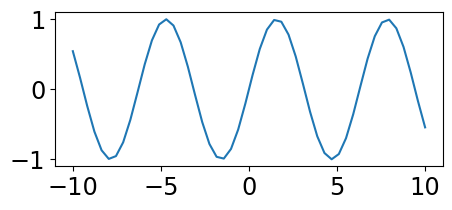

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-10-01'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters,dumpfitparameters
from spectractor.extractor.spectrum import Spectrum, detect_lines, calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA ,O2_1, O2_2, O2B,H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [12]:
from time import sleep

In [13]:
from astropy.time import Time
import astropy.units as u

In [14]:
import pickle

# Calibration line

In [15]:
ATMOSPHERIC_LINES_CALIB = [O2B,O2_1, O2_2]
HYDROGEN_LINES_CALIB = [HALPHA, HBETA, HGAMMA, HDELTA]

setatml = set(ATMOSPHERIC_LINES_CALIB)
sethdryl = set(HYDROGEN_LINES_CALIB )

LINES_CALIB = list(sethdryl.union(setatml))

lines_calib = Lines(LINES_CALIB , hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)

# Function

In [16]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [17]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [18]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [19]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [20]:
# path index for each month
DATE="20220628"
#DATE="20211104"
#filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
filterdispersername = "FELH0600~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"
FLAG_RECALIB = False

In [21]:
version="v5.0"

In [22]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1D_BG40.ini']
config_idx = 0
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [23]:
configdir 

'config_DECONVOLUTION_PSF1D'

In [24]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini


In [25]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


In [26]:
configmode = list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_DECONVOLUTION_")[-1].split(".") [0]
configmode

'PSF1D'

## Parameters

In [27]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 4096
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.0952
CCD_PIXEL2MM 0.01
CCD_REBIN 1
CONFIG_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/
DISPLAY False
DISTANCE2CCD 175
DISTANCE2CCD_ERR 0.75
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_PER_MM 350
HAL

# Path

In [28]:
HOSTCC=True
LAPTOP=False

In [29]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
        


In [30]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628'

In [31]:
! ls -l $path_output_spectractor

total 0
drwxrws--- 1 dagoret lsst 2 Oct  1 21:33 2022062800143
drwxrws--- 1 dagoret lsst 2 Oct  1 21:33 2022062800144
drwxrws--- 1 dagoret lsst 2 Oct  1 21:33 2022062800145
drwxrws--- 1 dagoret lsst 2 Oct  1 21:33 2022062800169
drwxrws--- 1 dagoret lsst 2 Oct  1 21:33 2022062800170
drwxrws--- 1 dagoret lsst 2 Oct  1 21:33 2022062800171
drwxrws--- 1 dagoret lsst 2 Oct  1 21:34 2022062800172
drwxrws--- 1 dagoret lsst 2 Oct  1 21:34 2022062800196
drwxrws--- 1 dagoret lsst 2 Oct  1 21:33 2022062800197
drwxrws--- 1 dagoret lsst 2 Oct  1 21:33 2022062800198
drwxrws--- 1 dagoret lsst 2 Oct  1 21:34 2022062800199
drwxrws--- 1 dagoret lsst 2 Oct  1 21:34 2022062800223
drwxrws--- 1 dagoret lsst 2 Oct  1 21:34 2022062800224
drwxrws--- 1 dagoret lsst 2 Oct  1 21:34 2022062800225
drwxrws--- 1 dagoret lsst 2 Oct  1 21:33 2022062800226
drwxrws--- 1 dagoret lsst 2 Oct  1 21:34 2022062800250
drwxrws--- 1 dagoret lsst 2 Oct  1 21:34 2022062800251
drwxrws--- 1 dagoret lsst 2 Oct  1 21:34 2022062800252
dr

In [32]:
# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
#config=os.path.join("./config",configfilename)
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini


In [33]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


## Logbook for file selection

In [34]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [35]:
df=pd.read_csv(filename_logbook,index_col=0)

In [36]:
pd.set_option('display.max_rows', None)

In [37]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2022-06-29T01:29:38.957,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2022062800143_postisrccd.fits,143,HD142331,FELH0600,holo4_003,1.090729,30.0,...,10.0,13.0,4.4,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2022-06-29T01:30:21.950,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2022062800144_postisrccd.fits,144,HD142331,FELH0600,holo4_003,1.090168,30.0,...,10.1,13.0,4.7,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2022-06-29T01:31:04.857,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2022062800145_postisrccd.fits,145,HD142331,FELH0600,holo4_003,1.089615,30.0,...,10.1,13.0,4.7,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2022-06-29T01:47:32.232,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2022062800169_postisrccd.fits,169,HD142331,FELH0600,holo4_003,1.079779,30.0,...,9.9,13.0,5.6,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2022-06-29T01:48:15.242,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2022062800170_postisrccd.fits,170,HD142331,FELH0600,holo4_003,1.079468,30.0,...,9.9,14.0,5.6,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2022-06-29T01:48:58.146,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2022062800171_postisrccd.fits,171,HD142331,FELH0600,holo4_003,1.079168,30.0,...,9.9,14.0,5.6,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2022-06-29T01:49:41.079,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2022062800172_postisrccd.fits,172,HD142331,FELH0600,holo4_003,1.078876,30.0,...,10.0,13.0,4.2,NaN,NaN,NaN,NaN,,NaN,NaN
7,7,2022-06-29T02:06:08.858,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2022062800196_postisrccd.fits,196,HD142331,FELH0600,holo4_003,1.074926,30.0,...,10.3,13.0,4.4,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2022-06-29T02:06:51.769,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2022062800197_postisrccd.fits,197,HD142331,FELH0600,holo4_003,1.074868,30.0,...,10.3,13.0,4.4,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2022-06-29T02:07:34.815,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2022062800198_postisrccd.fits,198,HD142331,FELH0600,holo4_003,1.074819,30.0,...,10.3,13.0,4.7,NaN,NaN,NaN,NaN,,NaN,NaN


## Selection of input files

In [38]:
df_good=df
df_good["quality"] = 1

In [39]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2022062800143_postisrccd.fits
exposure_2022062800144_postisrccd.fits
exposure_2022062800145_postisrccd.fits
exposure_2022062800169_postisrccd.fits
exposure_2022062800170_postisrccd.fits
exposure_2022062800171_postisrccd.fits
exposure_2022062800172_postisrccd.fits
exposure_2022062800196_postisrccd.fits
exposure_2022062800197_postisrccd.fits
exposure_2022062800198_postisrccd.fits
exposure_2022062800199_postisrccd.fits
exposure_2022062800223_postisrccd.fits
exposure_2022062800224_postisrccd.fits
exposure_2022062800225_postisrccd.fits
exposure_2022062800226_postisrccd.fits
exposure_2022062800250_postisrccd.fits
exposure_2022062800251_postisrccd.fits
exposure_2022062800252_postisrccd.fits
exposure_2022062800253_postisrccd.fits
exposure_2022062800312_postisrccd.fits
exposure_2022062800313_postisrccd.fits
exposure_2022062800315_postisrccd.fits
exposure_2022062800339_postisrccd.fits
exposure_2022062800340_postisrccd.fits
exposure_2022062800341_postisrccd.fits
exposure_2022062800342_po

## Selection of Spectractor output files

In [40]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [41]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
    
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2022062800143', '2022062800144', '2022062800145', '2022062800169', '2022062800170', '2022062800171', '2022062800172', '2022062800196', '2022062800197', '2022062800198', '2022062800199', '2022062800223', '2022062800224', '2022062800225', '2022062800226', '2022062800250', '2022062800251', '2022062800252', '2022062800253', '2022062800312', '2022062800313', '2022062800315', '2022062800339', '2022062800340', '2022062800341', '2022062800342', '2022062800366', '2022062800367', '2022062800368', '2022062800369', '2022062800397', '2022062800399', '2022062800400', '2022062800424', '2022062800425', '2022062800426', '2022062800427', '2022062800451', '2022062800452', '2022062800453', '2022062800454', '2022062800479', '2022062800480', '2022062800481', '2022062800506', '2022062800507', '2022062800508', '2022062800537', '2022062800538', '2022062800540', '2022062800564', '2022062800565', '2022062800566', '2022062800567', '2022062800591', '2022062800593', '2022062800594', '2022062

In [42]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800143/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800144/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800145/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800169/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800170/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800171/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800172/ba

In [43]:
config

'./config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini'

## Extraction of spectra

In [44]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [45]:
all_files_spectra[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800143/basespec/exposure_2022062800143_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800144/basespec/exposure_2022062800144_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800145/basespec/exposure_2022062800145_postisrccd_spectrum.fits']

In [46]:
all_files_spectrogram[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800143/basespec/exposure_2022062800143_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800144/basespec/exposure_2022062800144_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800145/basespec/exposure_2022062800145_postisrccd_spectrogram.fits']

In [47]:
all_files_lines[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800143/basespec/exposure_2022062800143_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800144/basespec/exposure_2022062800144_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800145/basespec/exposure_2022062800145_postisrccd_lines.csv']

In [48]:
all_files_table[:3] 

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800143/basespec/exposure_2022062800143_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800144/basespec/exposure_2022062800144_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800145/basespec/exposure_2022062800145_postisrccd_table.csv']

## Selection of good spectra

In [49]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [50]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

## One Spectrum

In [51]:
#idx=7 # Big Shift
#idx = 8 # Shift, I don't know why
idx = 9 # OK
#idx = 10 # OK
#idx = 11 # OK
#idx = 12 # 0K
#idx = 13 # strange shift after recalib
#idx = 14 # OK
#idx = 15 # Shift
#idx = 16 # BAD Spectrum Nothing
#idx = 17 # OK
#idx = 18 # trange shift after recalib
#idx = 19 # OK
#idx = 20 # OK
#idx = 21 # OK
#idx = 22 # BAD Spectrum
#idx = 24 # OK


fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])

    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
label = str(idx) +"):"+label
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True,label=label)

   
if FLAG_RECALIB: 
    parameters.DEBUG=True
    parameters.LIVE_FIT=True
    ax2 = fig.add_subplot(3, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    newlambdas = calibrate_spectrum(s, with_adr=True)
    label=str(idx) +"):"+filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
    
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(newlambdas,s.data,"r-")
    s.lines.plot_detected_lines(ax=ax3)
    s.lines.plot_atomic_lines(ax=ax3,force=True)
    ax3.set_xlim(parameters.LAMBDA_MIN, parameters.LAMBDA_MAX)
    ax3.grid()
    
    

plt.show()
    

9 ) exposure_2022062800198_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800198/basespec/exposure_2022062800198_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:08:05.052
set expo to 30.0
set airmass to 1.074804172831867
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -0.7947863681254342
set temperature to 10.3
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 756.411358951963
set parallactic_angle to -178.140905884495


2022-10-01 21:41:54  astropy    _showwarning         WARNING AstropyDeprecationWarning: The update_default_config function is deprecated and may be removed in a future version.
2022-10-01 21:41:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


target_name = HD142331, Selected object name for Simbad : HD142331
 MAIN_ID        RA           DEC      ...  Z_VALUE   SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1


In [52]:
parameters.DEBUG=False
parameters.LIVE_FIT=False

## All Spectra

In [53]:
parameters.DISPLAY=True

FLAG_ORDER2 = True

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]

if FLAG_ORDER2:
    all_lambdas_order2=[]
    all_data_order2=[]
    all_data_err_order2=[]

all_num=[]
all_figs = []


idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename = os.path.basename(fullfilename)
    print("============================",idx,")",filename," ",fullfilename,"==============================")
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    label = str(idx) +"):"+label
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    print("=== ORIGINAL CALIB lines === ")
    s.lines.print_detected_lines(print_table=True)
    
    if FLAG_RECALIB: 
        print(" === RECALIBRATE lines === ")
        s.lines = lines_calib
        lambdas = calibrate_spectrum(s, with_adr=False)
        label=filename.split('.')[0]+" recalibrated"
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
        t=s.lines.print_detected_lines(print_table=True)
        print(t["Shift"])
    
    
    
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    all_data_err.append(s.err)
    
    if FLAG_ORDER2:
        all_lambdas_order2.append(s.lambdas_order2)
        all_data_order2.append(s.data_order2)
        all_data_err_order2.append(s.err_order2)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=all_files_spectrogram[idx]
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    all_figs.append(fig)
    
    idx+=1
    

============================ 0 ) exposure_2022062800143_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800143/basespec/exposure_2022062800143_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:30:09.184
set expo to 30.0
set airmass to 1.090513483519696
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -10.297111619634
set temperature to 10.0
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 757.9747920312597
set parallactic_angle to -157.4147595091962
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:41:56  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_2  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 1 ) exposure_2022062800144_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800144/basespec/exposure_2022062800144_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:30:52.191
set expo to 30.0
set airmass to 1.089955516295561
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -10.1180676766439
set temperature to 10.1
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 757.18071

2022-10-01 21:41:57  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_3  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 2 ) exposure_2022062800145_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800145/basespec/exposure_2022062800145_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:31:35.094
set expo to 30.0
set airmass to 1.089408160049457
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -9.938397936085016
set temperature to 10.1
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 757.9445

2022-10-01 21:41:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_4  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 3 ) exposure_2022062800169_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800169/basespec/exposure_2022062800169_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:48:02.467
set expo to 30.0
set airmass to 1.079659733704435
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -5.816923580499946
set temperature to 9.9
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref 

2022-10-01 21:42:00  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_5  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 4 ) exposure_2022062800170_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800170/basespec/exposure_2022062800170_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:48:45.479
set expo to 30.0
set airmass to 1.079352157522991
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -5.63724910552525
set temperature to 9.9
set pressure to 745.9000000000001
set humidity to 14.0
set lambda_ref t

2022-10-01 21:42:01  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_6  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 5 ) exposure_2022062800171_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800171/basespec/exposure_2022062800171_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:49:28.371
set expo to 30.0
set airmass to 1.079055314435104
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -5.458407426703421
set temperature to 9.9
set pressure to 745.9000000000001
set humidity to 14.0
set lambda_ref 

2022-10-01 21:42:02  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_7  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 6 ) exposure_2022062800172_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800172/basespec/exposure_2022062800172_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:50:11.314
set expo to 30.0
set airmass to 1.078768091712448
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -5.278520666185984
set temperature to 10.0
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref

2022-10-01 21:42:03  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_8  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 7 ) exposure_2022062800196_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800196/basespec/exposure_2022062800196_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:06:39.101
set expo to 30.0
set airmass to 1.074903695700158
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -1.154136794200074
set temperature to 10.3
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 755.9435

2022-10-01 21:42:05  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_9  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 8 ) exposure_2022062800197_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800197/basespec/exposure_2022062800197_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:07:22.007
set expo to 30.0
set airmass to 1.074849114001341
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -0.9744609639342364
set temperature to 10.3
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 755.913

2022-10-01 21:42:06  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_10 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 9 ) exposure_2022062800198_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800198/basespec/exposure_2022062800198_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:08:05.052
set expo to 30.0
set airmass to 1.074804172831867
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -0.7947863681254342
set temperature to 10.3
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 756.411

2022-10-01 21:42:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_11 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 10 ) exposure_2022062800199_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800199/basespec/exposure_2022062800199_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:08:48.056
set expo to 30.0
set airmass to 1.0747689181349
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -0.6151088373007718
set temperature to 10.3
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 756.1897

2022-10-01 21:42:08  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_12 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 11 ) exposure_2022062800223_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800223/basespec/exposure_2022062800223_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:25:12.325
set expo to 30.0
set airmass to 1.076663046502389
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 3.49589087624095
set temperature to 10.4
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref 

2022-10-01 21:42:09  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_13 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 12 ) exposure_2022062800224_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800224/basespec/exposure_2022062800224_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:25:55.332
set expo to 30.0
set airmass to 1.076859096660725
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 3.675568004020992
set temperature to 10.5
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 756.895

2022-10-01 21:42:10  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_14 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 13 ) exposure_2022062800225_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800225/basespec/exposure_2022062800225_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:26:38.245
set expo to 30.0
set airmass to 1.077064781074946
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 3.855245005729695
set temperature to 10.5
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 756.960

2022-10-01 21:42:12  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_15 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 14 ) exposure_2022062800226_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800226/basespec/exposure_2022062800226_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:27:21.261
set expo to 30.0
set airmass to 1.077280349420556
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 4.035130693224571
set temperature to 10.5
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref

2022-10-01 21:42:13  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_16 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 15 ) exposure_2022062800250_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800250/basespec/exposure_2022062800250_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:43:47.760
set expo to 30.0
set airmass to 1.084988251039743
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 8.155934728030802
set temperature to 10.9
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 764.596

2022-10-01 21:42:14  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_17 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 16 ) exposure_2022062800251_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800251/basespec/exposure_2022062800251_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:44:30.770
set expo to 30.0
set airmass to 1.085441162958946
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 8.335606207383533
set temperature to 10.9
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 1116.26

2022-10-01 21:42:16  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_18 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 17 ) exposure_2022062800252_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800252/basespec/exposure_2022062800252_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:45:13.778
set expo to 30.0
set airmass to 1.085903105742179
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 8.515276910717356
set temperature to 10.9
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 758.435

2022-10-01 21:42:17  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_19 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 18 ) exposure_2022062800253_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800253/basespec/exposure_2022062800253_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:45:56.862
set expo to 30.0
set airmass to 1.086378785497961
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 8.695785493720471
set temperature to 10.9
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 757.955

2022-10-01 21:42:19  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_20 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 19 ) exposure_2022062800312_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800312/basespec/exposure_2022062800312_postisrccd_spectrum.fits ==============================


/tmp/ipykernel_1687/2289102767.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(16,4))


No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T03:52:28.527
set expo to 30.0
set airmass to 1.875766944937251
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -44.5782955575253
set temperature to 10.8
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 760.66758240507
set parallactic_angle to -45.66053910655361
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-01 21:42:20  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_21 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 20 ) exposure_2022062800313_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800313/basespec/exposure_2022062800313_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T03:53:11.535
set expo to 30.0
set airmass to 1.875467947634682
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -44.39862180451795
set temperature to 10.8
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 760.801

2022-10-01 21:42:21  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_22 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 21 ) exposure_2022062800315_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800315/basespec/exposure_2022062800315_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T03:54:37.455
set expo to 30.0
set airmass to 1.874874667355543
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -44.03990414096455
set temperature to 10.8
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 761.042

2022-10-01 21:42:23  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_23 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 22 ) exposure_2022062800339_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800339/basespec/exposure_2022062800339_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:11:41.411
set expo to 30.0
set airmass to 1.510047193259159
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -56.00504312336566
set temperature to 10.9
set pressure to 745.75
set humidity to 13.0
set lambda_ref to 758.61

2022-10-01 21:42:26  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_24 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 23 ) exposure_2022062800340_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800340/basespec/exposure_2022062800340_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:12:24.505
set expo to 30.0
set airmass to 1.505511193608462
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -55.82452828842712
set temperature to 10.9
set pressure to 745.75
set humidity to 13.0
set lambda_ref to 746.87

2022-10-01 21:42:27  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_25 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 24 ) exposure_2022062800341_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800341/basespec/exposure_2022062800341_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:13:07.511
set expo to 30.0
set airmass to 1.501035276007976
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -55.64484972685771
set temperature to 10.9
set pressure to 745.7
set humidity to 13.0
set lambda_ref to 749.302

2022-10-01 21:42:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_26 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 25 ) exposure_2022062800342_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800342/basespec/exposure_2022062800342_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:13:50.597
set expo to 30.0
set airmass to 1.496592813973071
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -55.46496158894749
set temperature to 10.9
set pressure to 745.7
set humidity to 13.0
set lambda_ref to 759.665

2022-10-01 21:42:30  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_27 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 26 ) exposure_2022062800366_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800366/basespec/exposure_2022062800366_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:30:15.862
set expo to 30.0
set airmass to 1.403972906625552
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -51.3485861529477
set temperature to 10.8
set pressure to 745.7
set humidity to 13.0
set lambda_ref to 749.7003

2022-10-01 21:42:32  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_28 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 27 ) exposure_2022062800367_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800367/basespec/exposure_2022062800367_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:30:58.797
set expo to 30.0
set airmass to 1.400306084317708
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -51.16890728670878
set temperature to 10.8
set pressure to 745.7
set humidity to 13.0
set lambda_ref to 758.492

2022-10-01 21:42:34  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_29 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 28 ) exposure_2022062800368_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800368/basespec/exposure_2022062800368_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:31:41.699
set expo to 30.0
set airmass to 1.39665905768601
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -50.98922809596483
set temperature to 10.9
set pressure to 745.7
set humidity to 12.0
set lambda_ref to 745.7690

2022-10-01 21:42:35  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_30 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 29 ) exposure_2022062800369_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800369/basespec/exposure_2022062800369_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:32:24.630
set expo to 30.0
set airmass to 1.393056952263406
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -50.81038551071038
set temperature to 10.9
set pressure to 745.7
set humidity to 12.0
set lambda_ref to 749.853

2022-10-01 21:42:37  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_31 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 30 ) exposure_2022062800397_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800397/basespec/exposure_2022062800397_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:01:50.349
set expo to 30.0
set airmass to 1.266038123470079
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -43.43787401918016
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 758.22

2022-10-01 21:42:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_32 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 31 ) exposure_2022062800399_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800399/basespec/exposure_2022062800399_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:03:16.284
set expo to 30.0
set airmass to 1.260793527568908
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -43.078518867144
set temperature to 11.1
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 745.26421

2022-10-01 21:42:40  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_33 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 32 ) exposure_2022062800400_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800400/basespec/exposure_2022062800400_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:03:59.289
set expo to 30.0
set airmass to 1.258201306610492
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -42.89884328261137
set temperature to 11.0
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 887.845

2022-10-01 21:42:42  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_34 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 33 ) exposure_2022062800424_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800424/basespec/exposure_2022062800424_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:20:23.157
set expo to 30.0
set airmass to 1.203891769201474
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -38.78787438000465
set temperature to 11.0
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 749.36

2022-10-01 21:42:43  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_35 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 34 ) exposure_2022062800425_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800425/basespec/exposure_2022062800425_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:21:06.225
set expo to 30.0
set airmass to 1.20171945561184
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -38.60736664192723
set temperature to 11.0
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 737.879

2022-10-01 21:42:45  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_36 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 35 ) exposure_2022062800426_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800426/basespec/exposure_2022062800426_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:21:49.203
set expo to 30.0
set airmass to 1.199572211425074
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -38.42832054115663
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 758.40

2022-10-01 21:42:46  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_37 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 36 ) exposure_2022062800427_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800427/basespec/exposure_2022062800427_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:22:32.240
set expo to 30.0
set airmass to 1.197432327750115
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -38.24780879238852
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 750.08

2022-10-01 21:42:48  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_38 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 37 ) exposure_2022062800451_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800451/basespec/exposure_2022062800451_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:38:50.514
set expo to 30.0
set airmass to 1.153001501007444
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -34.16078048443718
set temperature to 11.1
set pressure to 745.6
set humidity to 12.0
set lambda_ref to 745.060

2022-10-01 21:42:50  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_39 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 38 ) exposure_2022062800452_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800452/basespec/exposure_2022062800452_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:39:33.591
set expo to 30.0
set airmass to 1.151211990970014
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -33.98026528968214
set temperature to 11.1
set pressure to 745.6
set humidity to 12.0
set lambda_ref to 758.040

2022-10-01 21:42:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_40 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 39 ) exposure_2022062800453_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800453/basespec/exposure_2022062800453_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:40:16.574
set expo to 30.0
set airmass to 1.149448675048615
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -33.80142257982871
set temperature to 11.1
set pressure to 745.65
set humidity to 12.0
set lambda_ref to 758.77

2022-10-01 21:42:53  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_41 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 40 ) exposure_2022062800454_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800454/basespec/exposure_2022062800454_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:40:59.657
set expo to 30.0
set airmass to 1.147689806306152
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -33.62090878763497
set temperature to 11.3
set pressure to 745.65
set humidity to 11.0
set lambda_ref to 748.82

2022-10-01 21:42:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_42 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 41 ) exposure_2022062800479_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800479/basespec/exposure_2022062800479_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:58:05.960
set expo to 30.0
set airmass to 1.109694443708472
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -29.33339701813606
set temperature to 11.0
set pressure to 745.65
set humidity to 12.0
set lambda_ref to 742.08

2022-10-01 21:42:56  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_43 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 42 ) exposure_2022062800480_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800480/basespec/exposure_2022062800480_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:58:48.970
set expo to 30.0
set airmass to 1.108256053975652
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -29.15372171202441
set temperature to 10.9
set pressure to 745.55
set humidity to 12.0
set lambda_ref to 746.66

2022-10-01 21:42:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_44 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 43 ) exposure_2022062800481_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800481/basespec/exposure_2022062800481_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:59:31.862
set expo to 30.0
set airmass to 1.106832755605855
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -28.97404799757907
set temperature to 10.9
set pressure to 745.55
set humidity to 12.0
set lambda_ref to 758.41

2022-10-01 21:43:00  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_45 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 44 ) exposure_2022062800506_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800506/basespec/exposure_2022062800506_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:16:33.833
set expo to 30.0
set airmass to 1.076251672814297
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -24.7044523137267
set temperature to 10.9
set pressure to 745.4000000000001
set humidity to 12.0
set lambda_ref

2022-10-01 21:43:02  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_46 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 45 ) exposure_2022062800507_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800507/basespec/exposure_2022062800507_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:17:16.732
set expo to 30.0
set airmass to 1.075104000574509
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -24.52561720764644
set temperature to 10.9
set pressure to 745.4000000000001
set humidity to 12.0
set lambda_re

2022-10-01 21:43:03  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_47 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 46 ) exposure_2022062800508_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800508/basespec/exposure_2022062800508_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:17:59.740
set expo to 30.0
set airmass to 1.073961310787669
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -24.34594333823889
set temperature to 10.9
set pressure to 745.4000000000001
set humidity to 12.0
set lambda_re

2022-10-01 21:43:05  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_48 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 47 ) exposure_2022062800537_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800537/basespec/exposure_2022062800537_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:38:57.640
set expo to 30.0
set airmass to 1.044920687800456
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -19.09218025311277
set temperature to 10.7
set pressure to 745.45
set humidity to 12.0
set lambda_ref to 756.96

2022-10-01 21:43:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_49 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 48 ) exposure_2022062800538_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800538/basespec/exposure_2022062800538_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:39:40.703
set expo to 30.0
set airmass to 1.044071610027308
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -18.91250584148907
set temperature to 10.5
set pressure to 745.35
set humidity to 12.0
set lambda_ref to 757.43

2022-10-01 21:43:09  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_50 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 49 ) exposure_2022062800540_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800540/basespec/exposure_2022062800540_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:41:06.797
set expo to 30.0
set airmass to 1.042401342144726
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -18.5529420035212
set temperature to 10.6
set pressure to 745.35
set humidity to 12.0
set lambda_ref to 746.287

2022-10-01 21:43:11  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_51 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 50 ) exposure_2022062800564_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800564/basespec/exposure_2022062800564_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:57:29.213
set expo to 30.0
set airmass to 1.025847236526316
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -14.4488873134878
set temperature to 10.7
set pressure to 745.2
set humidity to 12.0
set lambda_ref to 750.6260

2022-10-01 21:43:13  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_52 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 51 ) exposure_2022062800565_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800565/basespec/exposure_2022062800565_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:58:12.140
set expo to 30.0
set airmass to 1.025228280929338
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -14.27005197366122
set temperature to 10.8
set pressure to 745.15
set humidity to 12.0
set lambda_ref to 751.87

2022-10-01 21:43:15  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_53 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 52 ) exposure_2022062800566_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800566/basespec/exposure_2022062800566_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:58:55.099
set expo to 30.0
set airmass to 1.024614826677954
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -14.09037852713206
set temperature to 10.8
set pressure to 745.1
set humidity to 12.0
set lambda_ref to 757.621

2022-10-01 21:43:16  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_54 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 53 ) exposure_2022062800567_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800567/basespec/exposure_2022062800567_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:59:38.063
set expo to 30.0
set airmass to 1.024009423349243
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -13.91070399847754
set temperature to 10.8
set pressure to 745.1
set humidity to 12.0
set lambda_ref to 757.695

2022-10-01 21:43:18  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_55 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 54 ) exposure_2022062800591_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800591/basespec/exposure_2022062800591_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:16:05.415
set expo to 30.0
set airmass to 1.012388217560895
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -9.788468133123311
set temperature to 11.0
set pressure to 744.9
set humidity to 12.0
set lambda_ref to 749.292

2022-10-01 21:43:20  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_56 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 55 ) exposure_2022062800593_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800593/basespec/exposure_2022062800593_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:17:31.357
set expo to 30.0
set airmass to 1.011577850006093
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -9.429944890437609
set temperature to 10.9
set pressure to 744.8
set humidity to 12.0
set lambda_ref to 734.893

2022-10-01 21:43:23  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_57 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 56 ) exposure_2022062800594_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800594/basespec/exposure_2022062800594_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:18:14.353
set expo to 30.0
set airmass to 1.011183711378336
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -9.25026994154322
set temperature to 10.9
set pressure to 744.85
set humidity to 12.0
set lambda_ref to 758.431

2022-10-01 21:43:25  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_58 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 57 ) exposure_2022062800625_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800625/basespec/exposure_2022062800625_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:42:30.828
set expo to 30.0
set airmass to 1.838949736643356
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 13.22521353657023
set temperature to 10.5
set pressure to 744.75
set humidity to 12.0
set lambda_ref to 760.508

2022-10-01 21:43:27  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_59 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 58 ) exposure_2022062800626_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800626/basespec/exposure_2022062800626_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:43:13.745
set expo to 30.0
set airmass to 1.839045480770292
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 13.40405054780786
set temperature to 10.5
set pressure to 744.7
set humidity to 12.0
set lambda_ref to 760.8623

2022-10-01 21:43:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_60 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 59 ) exposure_2022062800627_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800627/basespec/exposure_2022062800627_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:43:56.756
set expo to 30.0
set airmass to 1.839142728072148
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 13.58393182983543
set temperature to 10.5
set pressure to 744.7
set humidity to 12.0
set lambda_ref to 760.5889

2022-10-01 21:43:31  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_61 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 60 ) exposure_2022062800628_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800628/basespec/exposure_2022062800628_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:44:39.664
set expo to 30.0
set airmass to 1.839240969692866
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 13.76360427323118
set temperature to 10.3
set pressure to 744.7
set humidity to 12.0
set lambda_ref to 758.2667

2022-10-01 21:43:33  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_62 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 61 ) exposure_2022062800654_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800654/basespec/exposure_2022062800654_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:23:40.062
set expo to 30.0
set airmass to 1.007374785430158
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 7.137264547674095
set temperature to 10.5
set pressure to 744.5999999999999
set humidity to 12.0
set lambda_ref

2022-10-01 21:43:35  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_63 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 62 ) exposure_2022062800655_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800655/basespec/exposure_2022062800655_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:24:22.965
set expo to 30.0
set airmass to 1.007679908499872
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 7.31610101314427
set temperature to 10.5
set pressure to 744.5999999999999
set humidity to 12.0
set lambda_ref 

2022-10-01 21:43:37  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_64 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 63 ) exposure_2022062800656_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800656/basespec/exposure_2022062800656_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:25:05.971
set expo to 30.0
set airmass to 1.007994035903896
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 7.495773557310881
set temperature to 10.5
set pressure to 744.5999999999999
set humidity to 12.0
set lambda_ref

2022-10-01 21:43:39  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_65 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 64 ) exposure_2022062800657_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800657/basespec/exposure_2022062800657_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:25:48.870
set expo to 30.0
set airmass to 1.008315388216825
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 7.674820275321337
set temperature to 10.5
set pressure to 744.5999999999999
set humidity to 11.0
set lambda_ref

2022-10-01 21:43:41  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_66 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 65 ) exposure_2022062800683_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800683/basespec/exposure_2022062800683_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:43:42.244
set expo to 30.0
set airmass to 1.018947055703525
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 12.16917759350604
set temperature to 10.3
set pressure to 744.5
set humidity to 12.0
set lambda_ref to 720.4267

2022-10-01 21:43:44  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_67 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 66 ) exposure_2022062800708_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800708/basespec/exposure_2022062800708_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T09:20:05.085
set expo to 30.0
set airmass to 1.862584435961343
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 37.45860202731566
set temperature to 10.4
set pressure to 744.15
set humidity to 12.0
set lambda_ref to 757.006

2022-10-01 21:43:46  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_68 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 67 ) exposure_2022062800709_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800709/basespec/exposure_2022062800709_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T09:20:48.222
set expo to 30.0
set airmass to 1.862847415273342
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 37.63911044497211
set temperature to 10.4
set pressure to 744.15
set humidity to 11.0
set lambda_ref to 760.326

2022-10-01 21:43:48  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_69 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 68 ) exposure_2022062800710_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800710/basespec/exposure_2022062800710_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T09:21:31.228
set expo to 30.0
set airmass to 1.863110776919938
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 37.81878466001365
set temperature to 10.4
set pressure to 744.15
set humidity to 11.0
set lambda_ref to 759.700

2022-10-01 21:43:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_70 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 


## Save figures in a pdf filename

In [54]:
def SaveFigSpectraInPdf(nbspecperpage=5):
    
    Nspec= len(all_good_spectra_spectrum_files)
    Nbpages = np.ceil(Nspec/nbspecperpage)
    idx_inpage = nbspecperpage
    idx_pagenum = 0
    idx = 0
    
    all_composed_figs = []
    
    for fullfilename in all_good_spectra_spectrum_files:
        
        if idx_inpage == nbspecperpage:
            idx_inpage = 1
            idx_pagenum += 1
            
            if idx_pagenum > 1:
                all_composed_figs.append(fig)
            
            # create a new figure 
            fig=plt.figure(figsize=(16,20))
        else:
            idx_inpage += 1   
                             
        idx_fig = 2*(idx_inpage-1)+1
        
        print(f"\t \t  SaveFigSpectraInPdf >>>>>>>>  spec num = {idx}, pagenum = {idx_pagenum}/{Nbpages}, idx_inpage = {idx_inpage}, idx_fig = {idx_fig}")        
       
        
    
        filename = os.path.basename(fullfilename)
        

        ax1 = fig.add_subplot(nbspecperpage, 2, idx_fig)
    
        filename= os.path.basename(fullfilename)
        tag=file_tag_forsorting(filename.split(".")[0])
     
     
        s=Spectrum(fullfilename, config=config,fast_load=False);
        label=filename.split('.')[0]+" "
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    
        ax2 = fig.add_subplot(nbspecperpage, 2, idx_fig+1)
    
        fullfilename2=all_files_spectrogram[idx]
    
        s.load_spectrogram(fullfilename2)
        s.plot_spectrogram(ax=ax2,scale="log")
    
        plt.show()
                           
        idx+=1
                           
        if idx == Nspec:
             all_composed_figs.append(fig)
                           
    return  all_composed_figs
    


In [55]:
def SaveFigSpectraSummaryInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum night 2022-03-16", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(14,8)):
    """
    """
    
    
    
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(thetitle)
    plt.show()
    return fig

In [56]:
def SaveFigSpectraSummaryBothInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(12,20)):
    """
    
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(2, 1,height_ratios=[1, 3] ,figure=fig)
    
    ax=fig.add_subplot(gs[0,0])
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx],label=label,color=all_colors[idx])
        #if delta !=0:
        #    ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
        #    plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            
        
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("superimposed spectra")
    
    #ax=fig.add_subplot(2,1,2)
    ax=fig.add_subplot(gs[1,0])
    
    
    idx=0
    for idx in range(NN):
        
        deltashift=idx*delta
        
        label=all_tag[idx]
        
        if delta ==0:
            
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
        elif delta !=0:
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(f"shifted spectra by $\\delta f = $ {delta:.3e}")
    
    
    plt.suptitle(thetitle,y=0.95,fontsize=20,fontweight="bold")
    #plt.tight_layout()
    plt.show()
    return fig
        
    
    

### Individual spectra

In [57]:
all_figs = SaveFigSpectraInPdf(nbspecperpage=5)

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 0, pagenum = 1/14.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:30:09.184
set expo to 30.0
set airmass to 1.090513483519696
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -10.297111619634
set temperature to 10.0
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 757.9747920312597
set parallactic_angle to -157.4147595091962
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:43:54  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_71 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 1, pagenum = 1/14.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:30:52.191
set expo to 30.0
set airmass to 1.089955516295561
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -10.1180676766439
set temperature to 10.1
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 757.1807128500957
set parallactic_angle to -157.7613452194454
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:43:56  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_72 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 2, pagenum = 1/14.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:31:35.094
set expo to 30.0
set airmass to 1.089408160049457
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -9.938397936085016
set temperature to 10.1
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 757.9445537084931
set parallactic_angle to -158.1112738843632
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:43:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_73 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 3, pagenum = 1/14.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:48:02.467
set expo to 30.0
set airmass to 1.079659733704435
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -5.816923580499946
set temperature to 9.9
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref to 757.2315599442285
set parallactic_angle to -166.6808709948838
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:43:59  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_74 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 4, pagenum = 1/14.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:48:45.479
set expo to 30.0
set airmass to 1.079352157522991
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -5.63724910552525
set temperature to 9.9
set pressure to 745.9000000000001
set humidity to 14.0
set lambda_ref to 757.866452392759
set parallactic_angle to -167.0755905950523
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:01  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_75 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 5, pagenum = 2/14.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:49:28.371
set expo to 30.0
set airmass to 1.079055314435104
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -5.458407426703421
set temperature to 9.9
set pressure to 745.9000000000001
set humidity to 14.0
set lambda_ref to 723.9004254513547
set parallactic_angle to -167.4699733968118
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:04  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_76 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 6, pagenum = 2/14.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:50:11.314
set expo to 30.0
set airmass to 1.078768091712448
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -5.278520666185984
set temperature to 10.0
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref to 757.6010690908998
set parallactic_angle to -167.8681255775702
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:06  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_77 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 7, pagenum = 2/14.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:06:39.101
set expo to 30.0
set airmass to 1.074903695700158
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -1.154136794200074
set temperature to 10.3
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 755.94359333193
set parallactic_angle to -177.3015906839078
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_78 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 8, pagenum = 2/14.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:07:22.007
set expo to 30.0
set airmass to 1.074849114001341
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -0.9744609639342364
set temperature to 10.3
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 755.9139406352982
set parallactic_angle to -177.7211044944318
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:09  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_79 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 9, pagenum = 2/14.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:08:05.052
set expo to 30.0
set airmass to 1.074804172831867
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -0.7947863681254342
set temperature to 10.3
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 756.411358951963
set parallactic_angle to -178.140905884495
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:11  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_80 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 10, pagenum = 3/14.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:08:48.056
set expo to 30.0
set airmass to 1.0747689181349
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -0.6151088373007718
set temperature to 10.3
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 756.1897906350781
set parallactic_angle to -178.5609513223665
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:13  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_81 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 11, pagenum = 3/14.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:25:12.325
set expo to 30.0
set airmass to 1.076663046502389
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 3.49589087624095
set temperature to 10.4
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref to 809.5557291972697
set parallactic_angle to 171.8844089153671
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:15  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_82 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 12, pagenum = 3/14.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:25:55.332
set expo to 30.0
set airmass to 1.076859096660725
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 3.675568004020992
set temperature to 10.5
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 756.8955278320486
set parallactic_angle to 171.4744040524388
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:18  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_83 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 13, pagenum = 3/14.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:26:38.245
set expo to 30.0
set airmass to 1.077064781074946
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 3.855245005729695
set temperature to 10.5
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 756.9609898091247
set parallactic_angle to 171.0654456709291
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:20  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_84 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 14, pagenum = 3/14.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:27:21.261
set expo to 30.0
set airmass to 1.077280349420556
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 4.035130693224571
set temperature to 10.5
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref to 758.1208376846688
set parallactic_angle to 170.6571061871564
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:22  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_85 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 15, pagenum = 4/14.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:43:47.760
set expo to 30.0
set airmass to 1.084988251039743
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 8.155934728030802
set temperature to 10.9
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 764.5967560501899
set parallactic_angle to 161.6950388087156
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:24  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_86 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 16, pagenum = 4/14.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:44:30.770
set expo to 30.0
set airmass to 1.085441162958946
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 8.335606207383533
set temperature to 10.9
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 1116.262109196479
set parallactic_angle to 161.3248332369489
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:26  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_87 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 17, pagenum = 4/14.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:45:13.778
set expo to 30.0
set airmass to 1.085903105742179
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 8.515276910717356
set temperature to 10.9
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 758.4358532104239
set parallactic_angle to 160.9565841811294
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:28  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_88 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 18, pagenum = 4/14.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:45:56.862
set expo to 30.0
set airmass to 1.086378785497961
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 8.695785493720471
set temperature to 10.9
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 757.955816629813
set parallactic_angle to 160.588608989673
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:44:31  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_89 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 19, pagenum = 4/14.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T03:52:28.527
set expo to 30.0
set airmass to 1.875766944937251
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -44.5782955575253
set temperature to 10.8
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 760.66758240507
set parallactic_angle to -45.66053910655361
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-01 21:44:33  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_90 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 20, pagenum = 5/14.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T03:53:11.535
set expo to 30.0
set airmass to 1.875467947634682
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -44.39862180451795
set temperature to 10.8
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 760.8017026818468
set parallactic_angle to -45.47756953048334
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-01 21:44:35  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_91 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 21, pagenum = 5/14.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T03:54:37.455
set expo to 30.0
set airmass to 1.874874667355543
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -44.03990414096455
set temperature to 10.8
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 761.0428185045422
set parallactic_angle to -45.11223575584535
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-01 21:44:37  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_92 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 22, pagenum = 5/14.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:11:41.411
set expo to 30.0
set airmass to 1.510047193259159
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -56.00504312336566
set temperature to 10.9
set pressure to 745.75
set humidity to 13.0
set lambda_ref to 758.6158238081216
set parallactic_angle to -107.511115955293
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:44:39  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_93 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 23, pagenum = 5/14.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:12:24.505
set expo to 30.0
set airmass to 1.505511193608462
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -55.82452828842712
set temperature to 10.9
set pressure to 745.75
set humidity to 13.0
set lambda_ref to 746.8757019264497
set parallactic_angle to -107.4708004321942
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:44:41  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_94 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 24, pagenum = 5/14.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:13:07.511
set expo to 30.0
set airmass to 1.501035276007976
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -55.64484972685771
set temperature to 10.9
set pressure to 745.7
set humidity to 13.0
set lambda_ref to 749.3029540818404
set parallactic_angle to -107.4308048025631
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:44:43  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_95 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 25, pagenum = 6/14.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:13:50.597
set expo to 30.0
set airmass to 1.496592813973071
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -55.46496158894749
set temperature to 10.9
set pressure to 745.7
set humidity to 13.0
set lambda_ref to 759.6656987788509
set parallactic_angle to -107.3908959743468
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:44:47  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_96 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 26, pagenum = 6/14.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:30:15.862
set expo to 30.0
set airmass to 1.403972906625552
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -51.3485861529477
set temperature to 10.8
set pressure to 745.7
set humidity to 13.0
set lambda_ref to 749.7003391769109
set parallactic_angle to -106.5152230339607
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:44:49  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_97 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 27, pagenum = 6/14.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:30:58.797
set expo to 30.0
set airmass to 1.400306084317708
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -51.16890728670878
set temperature to 10.8
set pressure to 745.7
set humidity to 13.0
set lambda_ref to 758.4920368122788
set parallactic_angle to -106.4786935072718
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:44:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_98 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 28, pagenum = 6/14.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:31:41.699
set expo to 30.0
set airmass to 1.39665905768601
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -50.98922809596483
set temperature to 10.9
set pressure to 745.7
set humidity to 12.0
set lambda_ref to 745.7690819388102
set parallactic_angle to -106.4423107387743
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:44:53  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_99 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 29, pagenum = 6/14.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:32:24.630
set expo to 30.0
set airmass to 1.393056952263406
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -50.81038551071038
set temperature to 10.9
set pressure to 745.7
set humidity to 12.0
set lambda_ref to 749.8531011140655
set parallactic_angle to -106.4062438756473
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:44:56  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_100 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 30, pagenum = 7/14.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:01:50.349
set expo to 30.0
set airmass to 1.266038123470079
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -43.43787401918016
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 758.2271368014028
set parallactic_angle to -105.0576748220411
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:44:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_101 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 31, pagenum = 7/14.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:03:16.284
set expo to 30.0
set airmass to 1.260793527568908
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -43.078518867144
set temperature to 11.1
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 745.2642103915792
set parallactic_angle to -104.9995434306243
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:01  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_102 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 32, pagenum = 7/14.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:03:59.289
set expo to 30.0
set airmass to 1.258201306610492
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -42.89884328261137
set temperature to 11.0
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 887.845231991985
set parallactic_angle to -104.9707732489166
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:04  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_103 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 33, pagenum = 7/14.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:20:23.157
set expo to 30.0
set airmass to 1.203891769201474
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -38.78787438000465
set temperature to 11.0
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 749.3635228308914
set parallactic_angle to -104.3706964683515
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:06  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_104 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 34, pagenum = 7/14.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:21:06.225
set expo to 30.0
set airmass to 1.20171945561184
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -38.60736664192723
set temperature to 11.0
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 737.8798714981272
set parallactic_angle to -104.3471160855434
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:09  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_105 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 35, pagenum = 8/14.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:21:49.203
set expo to 30.0
set airmass to 1.199572211425074
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -38.42832054115663
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 758.4090645974564
set parallactic_angle to -104.3239767623733
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:11  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_106 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 36, pagenum = 8/14.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:22:32.240
set expo to 30.0
set airmass to 1.197432327750115
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -38.24780879238852
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 750.0852933258798
set parallactic_angle to -104.3009029616821
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:14  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_107 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 37, pagenum = 8/14.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:38:50.514
set expo to 30.0
set airmass to 1.153001501007444
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -34.16078048443718
set temperature to 11.1
set pressure to 745.6
set humidity to 12.0
set lambda_ref to 745.0603364997801
set parallactic_angle to -103.854000345115
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:16  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_108 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 38, pagenum = 8/14.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:39:33.591
set expo to 30.0
set airmass to 1.151211990970014
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -33.98026528968214
set temperature to 11.1
set pressure to 745.6
set humidity to 12.0
set lambda_ref to 758.0407642703691
set parallactic_angle to -103.8379515367956
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:19  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_109 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 39, pagenum = 8/14.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:40:16.574
set expo to 30.0
set airmass to 1.149448675048615
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -33.80142257982871
set temperature to 11.1
set pressure to 745.65
set humidity to 12.0
set lambda_ref to 758.7784910775927
set parallactic_angle to -103.8223930532671
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:22  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_110 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 40, pagenum = 9/14.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:40:59.657
set expo to 30.0
set airmass to 1.147689806306152
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -33.62090878763497
set temperature to 11.3
set pressure to 745.65
set humidity to 11.0
set lambda_ref to 748.8219824360582
set parallactic_angle to -103.8070387489019
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:25  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_111 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 41, pagenum = 9/14.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:58:05.960
set expo to 30.0
set airmass to 1.109694443708472
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -29.33339701813606
set temperature to 11.0
set pressure to 745.65
set humidity to 12.0
set lambda_ref to 742.0845573579317
set parallactic_angle to -103.5596405366393
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:27  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_112 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 42, pagenum = 9/14.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:58:48.970
set expo to 30.0
set airmass to 1.108256053975652
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -29.15372171202441
set temperature to 10.9
set pressure to 745.55
set humidity to 12.0
set lambda_ref to 746.6688310598062
set parallactic_angle to -103.554876084715
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:30  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_113 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 43, pagenum = 9/14.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:59:31.862
set expo to 30.0
set airmass to 1.106832755605855
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -28.97404799757907
set temperature to 10.9
set pressure to 745.55
set humidity to 12.0
set lambda_ref to 758.4116234832685
set parallactic_angle to -103.5506271328343
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:33  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_114 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 44, pagenum = 9/14.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:16:33.833
set expo to 30.0
set airmass to 1.076251672814297
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -24.7044523137267
set temperature to 10.9
set pressure to 745.4000000000001
set humidity to 12.0
set lambda_ref to 758.491500453127
set parallactic_angle to -103.6271439078788
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:35  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_115 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 45, pagenum = 10/14.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:17:16.732
set expo to 30.0
set airmass to 1.075104000574509
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -24.52561720764644
set temperature to 10.9
set pressure to 745.4000000000001
set humidity to 12.0
set lambda_ref to 744.6719098018713
set parallactic_angle to -103.6390730547897
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_116 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 46, pagenum = 10/14.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:17:59.740
set expo to 30.0
set airmass to 1.073961310787669
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -24.34594333823889
set temperature to 10.9
set pressure to 745.4000000000001
set humidity to 12.0
set lambda_ref to 750.6140638350375
set parallactic_angle to -103.6518895031496
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:42  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_117 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 47, pagenum = 10/14.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:38:57.640
set expo to 30.0
set airmass to 1.044920687800456
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -19.09218025311277
set temperature to 10.7
set pressure to 745.45
set humidity to 12.0
set lambda_ref to 756.9673537466438
set parallactic_angle to -104.4960261705977
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:44  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_118 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 48, pagenum = 10/14.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:39:40.703
set expo to 30.0
set airmass to 1.044071610027308
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -18.91250584148907
set temperature to 10.5
set pressure to 745.35
set humidity to 12.0
set lambda_ref to 757.4378135528074
set parallactic_angle to -104.545420099333
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:47  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_119 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 49, pagenum = 10/14.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:41:06.797
set expo to 30.0
set airmass to 1.042401342144726
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -18.5529420035212
set temperature to 10.6
set pressure to 745.35
set humidity to 12.0
set lambda_ref to 746.2874892352802
set parallactic_angle to -104.6495433329885
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:50  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_120 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 50, pagenum = 11/14.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:57:29.213
set expo to 30.0
set airmass to 1.025847236526316
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -14.4488873134878
set temperature to 10.7
set pressure to 745.2
set humidity to 12.0
set lambda_ref to 750.6260001279463
set parallactic_angle to -106.485730036644
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:53  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_121 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 51, pagenum = 11/14.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:58:12.140
set expo to 30.0
set airmass to 1.025228280929338
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -14.27005197366122
set temperature to 10.8
set pressure to 745.15
set humidity to 12.0
set lambda_ref to 751.8715204741524
set parallactic_angle to -106.6010181761642
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:56  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_122 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 52, pagenum = 11/14.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:58:55.099
set expo to 30.0
set airmass to 1.024614826677954
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -14.09037852713206
set temperature to 10.8
set pressure to 745.1
set humidity to 12.0
set lambda_ref to 757.6213738942056
set parallactic_angle to -106.7206845981074
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:45:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_123 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 53, pagenum = 11/14.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:59:38.063
set expo to 30.0
set airmass to 1.024009423349243
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -13.91070399847754
set temperature to 10.8
set pressure to 745.1
set humidity to 12.0
set lambda_ref to 757.6958247458418
set parallactic_angle to -106.8443362348442
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:46:02  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_124 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 54, pagenum = 11/14.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:16:05.415
set expo to 30.0
set airmass to 1.012388217560895
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -9.788468133123311
set temperature to 11.0
set pressure to 744.9
set humidity to 12.0
set lambda_ref to 749.2922716683286
set parallactic_angle to -111.2198912539336
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:46:05  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_125 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 55, pagenum = 12/14.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:17:31.357
set expo to 30.0
set airmass to 1.011577850006093
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -9.429944890437609
set temperature to 10.9
set pressure to 744.8
set humidity to 12.0
set lambda_ref to 734.8936275023334
set parallactic_angle to -111.7999299251161
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:46:08  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_126 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 56, pagenum = 12/14.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:18:14.353
set expo to 30.0
set airmass to 1.011183711378336
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -9.25026994154322
set temperature to 10.9
set pressure to 744.85
set humidity to 12.0
set lambda_ref to 758.4318182346504
set parallactic_angle to -112.1078210696617
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:46:11  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_127 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 57, pagenum = 12/14.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:42:30.828
set expo to 30.0
set airmass to 1.838949736643356
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 13.22521353657023
set temperature to 10.5
set pressure to 744.75
set humidity to 12.0
set lambda_ref to 760.5082920468581
set parallactic_angle to 13.58401685328957
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-01 21:46:14  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_128 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 58, pagenum = 12/14.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:43:13.745
set expo to 30.0
set airmass to 1.839045480770292
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 13.40405054780786
set temperature to 10.5
set pressure to 744.7
set humidity to 12.0
set lambda_ref to 760.8623185278271
set parallactic_angle to 13.76760045317304
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-01 21:46:17  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_129 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 59, pagenum = 12/14.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:43:56.756
set expo to 30.0
set airmass to 1.839142728072148
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 13.58393182983543
set temperature to 10.5
set pressure to 744.7
set humidity to 12.0
set lambda_ref to 760.5889137028829
set parallactic_angle to 13.95225178731025
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-01 21:46:20  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_130 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 60, pagenum = 13/14.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:44:39.664
set expo to 30.0
set airmass to 1.839240969692866
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 13.76360427323118
set temperature to 10.3
set pressure to 744.7
set humidity to 12.0
set lambda_ref to 758.2667571158987
set parallactic_angle to 14.13668443178679
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-01 21:46:25  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_131 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 61, pagenum = 13/14.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:23:40.062
set expo to 30.0
set airmass to 1.007374785430158
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 7.137264547674095
set temperature to 10.5
set pressure to 744.5999999999999
set humidity to 12.0
set lambda_ref to 745.2606777823212
set parallactic_angle to 116.8461123450126
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:46:28  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_132 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 62, pagenum = 13/14.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:24:22.965
set expo to 30.0
set airmass to 1.007679908499872
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 7.31610101314427
set temperature to 10.5
set pressure to 744.5999999999999
set humidity to 12.0
set lambda_ref to 745.986643224979
set parallactic_angle to 116.3470938986958
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:46:31  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_133 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 63, pagenum = 13/14.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:25:05.971
set expo to 30.0
set airmass to 1.007994035903896
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 7.495773557310881
set temperature to 10.5
set pressure to 744.5999999999999
set humidity to 12.0
set lambda_ref to 750.7681081101119
set parallactic_angle to 115.8673356642777
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:46:35  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_134 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 64, pagenum = 13/14.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:25:48.870
set expo to 30.0
set airmass to 1.008315388216825
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 7.674820275321337
set temperature to 10.5
set pressure to 744.5999999999999
set humidity to 11.0
set lambda_ref to 745.4045124542886
set parallactic_angle to 115.4096043750722
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:46:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_135 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 65, pagenum = 14/14.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:43:42.244
set expo to 30.0
set airmass to 1.018947055703525
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 12.16917759350604
set temperature to 10.3
set pressure to 744.5
set humidity to 12.0
set lambda_ref to 720.4267596588463
set parallactic_angle to 108.2818110700942
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-01 21:46:41  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_136 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 66, pagenum = 14/14.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T09:20:05.085
set expo to 30.0
set airmass to 1.862584435961343
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 37.45860202731566
set temperature to 10.4
set pressure to 744.15
set humidity to 12.0
set lambda_ref to 757.0063404397573
set parallactic_angle to 38.4013472343759
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-01 21:46:45  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_137 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 67, pagenum = 14/14.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T09:20:48.222
set expo to 30.0
set airmass to 1.862847415273342
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 37.63911044497211
set temperature to 10.4
set pressure to 744.15
set humidity to 11.0
set lambda_ref to 760.3266852684817
set parallactic_angle to 38.58560940501956
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-01 21:46:49  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_138 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 68, pagenum = 14/14.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T09:21:31.228
set expo to 30.0
set airmass to 1.863110776919938
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 37.81878466001365
set temperature to 10.4
set pressure to 744.15
set humidity to 11.0
set lambda_ref to 759.7006466993131
set parallactic_angle to 38.76900927817073
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-01 21:46:53  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_139 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1


### Summary spectra

In [58]:
thetitle = f"Superimposed hologram spectra, night{DATE} (config {configdir})"
sumfig = SaveFigSpectraSummaryInPdf(all_lambdas,all_data,all_num,delta=0, thetitle=thetitle)

In [59]:
all_figs.append(sumfig)

In [60]:
thetitle2 = f"Superimposed and shifted hologram spectra, night{DATE} (config {configdir})"
sumfig2 = SaveFigSpectraSummaryBothInPdf(all_lambdas,all_data,all_num,delta=0.1e-11,thetitle=thetitle2)

In [61]:
all_figs.append(sumfig2)

### Save in pdf file

In [62]:
# Write all images in pdf files

#multipage_pdf_file = f'multipage_pdf_holo_{DATE}_{configdir}.pdf'
# gerate a multipage pdf:
#with PdfPages(multipage_pdf_file) as pdf:
#    for fig in all_figs:
#        pdf.savefig(fig)
#        plt.close()


## View one spectrum

In [63]:
idx=3

fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])
all_num.append(tag)
    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True)

#ax2 = fig.add_subplot(1, 2, 2)
    
#fullfilename2=all_files_spectrogram[idx]
    
#s.load_spectrogram(fullfilename2)
#s.plot_spectrogram(ax=ax2,scale="log")
    

plt.show()
    
    
    
if FLAG_RECALIB: 
    ax2 = fig.add_subplot(2, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    lambdas = calibrate_spectrum(s, with_adr=False)
    label=filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
        

3 ) exposure_2022062800169_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220628/2022062800169/basespec/exposure_2022062800169_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:48:02.467
set expo to 30.0
set airmass to 1.079659733704435
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -5.816923580499946
set temperature to 9.9
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref to 757.2315599442285
set parallactic_angle to -166.6808709948838
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-01 21:46:57  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_140 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ...  -0.0002360                1


In [64]:
all_figs.append(fig)

## Info

In [65]:
df_infos=pd.DataFrame(infos,columns=["idx","object","date_obs","airmass","temperature","pressure","humidity"])

In [66]:
df_infos.set_index('idx',inplace=True)

In [67]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [68]:
all_reftime=np.array(all_reftime)

In [69]:
df_infos["reftime"]=all_reftime

In [70]:
NN = len(df_infos)

In [71]:
df_infos

,object,date_obs,airmass,temperature,pressure,humidity,reftime
idx,,,,,,,
0,HD142331,2022-06-29T01:30:09.184,1.090513,10.0,745.80,13.0,0.000000
1,HD142331,2022-06-29T01:30:52.191,1.089956,10.1,745.80,13.0,0.011946
2,HD142331,2022-06-29T01:31:35.094,1.089408,10.1,745.80,13.0,0.023864
3,HD142331,2022-06-29T01:48:02.467,1.079660,9.9,745.90,13.0,0.298134
4,HD142331,2022-06-29T01:48:45.479,1.079352,9.9,745.90,14.0,0.310082
5,HD142331,2022-06-29T01:49:28.371,1.079055,9.9,745.90,14.0,0.321996
6,HD142331,2022-06-29T01:50:11.314,1.078768,10.0,745.90,13.0,0.333925
7,HD142331,2022-06-29T02:06:39.101,1.074904,10.3,746.00,13.0,0.608310
8,HD142331,2022-06-29T02:07:22.007,1.074849,10.3,746.00,13.0,0.620229


In [72]:
configmode

'PSF1D'

In [73]:
#summary_file = f"summaryspectra_{DATE}_{configdir}.csv"
summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configdir}.csv"
df_infos.to_csv(summary_file)

In [74]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel("airmass")
ax.legend(loc="upper right")

ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.legend(loc="upper left")
ax.set_title("airmassvs vs date")

Text(0.5, 1.0, 'airmassvs vs date')

In [75]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
p1,= ax.plot(df_infos['reftime'], df_infos['airmass'],marker="o",color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.set_xlim(0,np.ceil(df_infos['reftime'].values.max()))
ax.set_ylabel("airmass")
ax2 = ax.twinx()
p2, = ax2.plot(df_infos['reftime'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.spines["right"].set_position(("axes", 0.9))

ax3 = ax.twinx()

ax3.spines["right"].set_position(("axes", 1.0))
p3, = ax3.plot(df_infos['reftime'], df_infos['temperature'],linestyle='dotted', marker='.',color="blue",label="temperature")
ax3.set_ylabel("temperature")

curves = [p1, p2, p3]
ax.legend(curves, [c.get_label() for c in curves])

ax.set_title(f"airmass vs time for night {DATE}")

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax3.yaxis.label.set_color(p3.get_color())

ax2.spines["right"].set_edgecolor(p2.get_color())
ax3.spines["right"].set_edgecolor(p3.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())
ax3.tick_params(axis='y', colors=p3.get_color())
plt.show()


In [76]:
all_figs.append(fig)

# Header info

In [77]:
NN=len(all_good_spectra_spectrum_files)

all_rebin=np.zeros(NN)
all_targetx=np.zeros(NN)
all_targety=np.zeros(NN)
all_rotangle=np.zeros(NN)
all_d2ccd=np.zeros(NN)
all_pixshift=np.zeros(NN)
all_chi2_fit=np.zeros(NN)
all_a2_fit=np.zeros(NN)
all_lbda_ref=np.zeros(NN)
all_tagnumber=np.zeros(NN)


for idx in range(NN):
    
    fullfilename=all_good_spectra_spectrum_files[idx]
    
    filename= os.path.basename(fullfilename)
    hdul=fits.open(fullfilename)
    header=hdul[0].header
    tagnum=str(all_num[idx])
    
    #ROTANGLE=  -0.1367006901184345 / [deg] angle of the dispersion axis             
    #D2CCD   =    179.6778868175837 / [mm] distance between disperser and CCD        
    #TARGETX =    315.9547462941386 / target position on X axis                      
    #TARGETY =    75.06785960446246 / target position on Y axis                      
    #LBDA_REF=    634.9155139280113                                                  
    #PIXSHIFT=  -0.9996981508176748                                                  
    #CHI2_FIT=    1.602115867259752                                                  
    #A2_FIT  =                  1.0                                                  
    #REBIN   =                    2 / original image rebinning factor to get spectrum
    
    rebin=header["REBIN"]
    targetx=header["TARGETX"]*rebin
    targety=header["TARGETY"]*rebin
    rotangle=header["ROTANGLE"]
    d2ccd=header["D2CCD"]
    pixshift=header["PIXSHIFT"]
    
    if header.get("CHI2_FIT") != None:
        chi2_fit=header["CHI2_FIT"]
    else:
        chi2_fit= -1
        
    if header.get("A2_FIT") != None:
        a2_fit=header["A2_FIT"]
    else:
        a2_fit=-1
    
    
    lbda_ref=header["LBDA_REF"]
    
    
    all_rebin[idx]=rebin
    all_targetx[idx]=targetx
    all_targety[idx]=targety
    all_rotangle[idx]=rotangle
    all_d2ccd[idx]=d2ccd
    all_pixshift[idx]=pixshift
    
    
    all_chi2_fit[idx]=chi2_fit
    all_a2_fit[idx]=a2_fit
    all_lbda_ref[idx]=lbda_ref
    all_tagnumber[idx]=tagnum
    

In [78]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1728                                                  
NAXIS2  =                    3                                                  
EXTEND  =                    T                                                  
DATE    = '2022-06-29T09:21:31.228'                                             
MJD     =    59759.38994476851                                                  
CCD_MANU= 'ITL     '                                                            
CCD_TYPE= '3800C   '                                                            
TESTTYPE= 'OBJECT  '                                                            
IMGTYPE = 'OBJECT  '                                                            
TEMP_SET=   -94.150000000000

In [79]:
fig=plt.figure(figsize=(18,25))

# rebin
ax=fig.add_subplot(10,1,1)
ax.plot(all_tagnumber,all_rebin,"b:o",label="rebin")
ax.legend()
ax.grid()
ax.set_title("rebin")

#targetx
ax=fig.add_subplot(10,1,2)
ax.plot(all_tagnumber,all_targetx,"b:o",label="targetx")
ax.legend()
ax.grid()
ax.set_title("targetx")



#targety
ax=fig.add_subplot(10,1,3)
ax.plot(all_tagnumber,all_targety,"b:o",label="targety")
ax.legend()
ax.grid()
ax.set_title("targety")



#rotangle
ax=fig.add_subplot(10,1,4)
ax.plot(all_tagnumber,all_rotangle,"b:o",label="rotangle")
ax.legend()
ax.grid()
ax.set_title("rotangle")

#d2ccd
ax=fig.add_subplot(10,1,5)
ax.plot(all_tagnumber,all_d2ccd,"b:o",label="d2ccd")
ax.legend()
ax.grid()
ax.set_title("d2ccd")


#pixshift
ax=fig.add_subplot(10,1,6)
ax.plot(all_tagnumber,all_pixshift,"b:o",label="pixshift")
ax.legend()
ax.grid()
ax.set_title("pixshift")


#chi2_fit
ax=fig.add_subplot(10,1,7)
ax.plot(all_tagnumber,all_chi2_fit,"b:o",label="chi2_fit")
ax.legend()
ax.grid()
ax.set_title("chi2_fit")

#a2_fit
ax=fig.add_subplot(10,1,8)
ax.plot(all_tagnumber,all_a2_fit,"b:o",label="a2_fit")
ax.legend()
ax.grid()
ax.set_title("a2_fit")


#all_lbda_ref
ax=fig.add_subplot(10,1,9)
ax.plot(all_tagnumber,all_lbda_ref,"bo",label="lbda_ref")
ax.legend()
ax.grid()
ax.set_title("lbda_ref")

ax.set_xlabel("tag number")
plt.tight_layout()
plt.show()


In [80]:
all_figs.append(fig)

# Write in pdf file

In [81]:
# Write all images in pdf files
if FLAG_RECALIB:  
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}_recalib.pdf'
else:
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}.pdf'
    
# gerate a multipage pdf:
with PdfPages(multipage_pdf_file) as pdf:
    for fig in all_figs:
        pdf.savefig(fig)
        plt.close()

# write in pickles files

In [82]:
all_out_data = {}

for idx in range(NN):
    if FLAG_ORDER2:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'], 
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
               'all_lambdas_order2':all_lambdas_order2[idx],
               'all_fluxes_order2':all_data_order2[idx],
               'all_fluxes_err_order2':all_data_err_order2[idx],
              }
    else:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'],
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
            }         
            
    all_out_data[os.path.basename(all_good_spectra_spectrum_files[idx])]=thedata


In [83]:
if FLAG_RECALIB: 
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}_recalib.pickle'
else:
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}.pickle'
    

with open(pkl_outfilename, 'wb') as pickle_file:
    pickle.dump(all_out_data,pickle_file)


In [84]:
pkl_infilename=pkl_outfilename

In [85]:
with open(pkl_infilename, 'rb') as pickle_file:
    content = pickle.load(pickle_file)


In [86]:
#content

In [87]:
# Get first value of dictionary
next(iter(content.items()))

('exposure_2022062800143_postisrccd_spectrum.fits',
 {'number': 143.0,
  'object': 'HD142331',
  'dateobs': '2022-06-29T01:30:09.184',
  'refhour': 0.0,
  'airmass': 1.090513483519696,
  'pressure': 745.8,
  'temperature': 10.0,
  'humidity': 13.0,
  'targetx_pix': 302.6608884242224,
  'targety_pix': 1731.975357182731,
  'rotangle': -0.28,
  'd2ccd': 180.4780772333291,
  'all_lambdas': array([ 502.22385103,  502.57596155,  502.92806725, ..., 1100.14801191,
         1100.48776452, 1100.82750762]),
  'all_fluxes': array([-3.03366244e-15, -2.68250030e-15, -8.28614695e-16, ...,
         -1.90403546e-15, -1.98316484e-16,  4.13264062e-16]),
  'all_fluxes_err': array([2.33407167e-15, 2.33525016e-15, 2.34860553e-15, ...,
         1.09621163e-15, 1.10858001e-15, 1.11541337e-15]),
  'all_lambdas_order2': array([251.11192551, 251.28798078, 251.46403363, ..., 550.07400595,
         550.24388226, 550.41375381]),
  'all_fluxes_order2': array([0., 0., 0., ..., 0., 0., 0.]),
  'all_fluxes_err_order2':